In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, TensorDataset, random_split
import pyswarms as ps
import pygad

## 2D Rosenbrock Approximation

In [2]:
def Rosenbrock(X,a=1,b=100):
    Z = (a - X[:,0]) ** 2 + b * (X[:,1] - X[:,0] ** 2) ** 2
    Z = Z / 1000
    return Z

In [3]:
def generate_data(num_points):
    points = np.random.uniform(-2.048,2.048, size=(num_points, 2))
    func_out = Rosenbrock(points)
    return points, func_out


In [4]:
def plot3d(xy,func_out):
    xy = np.array(xy)
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca(projection='3d')
    ax.scatter(xy[:,0], xy[:,1], func_out)
    plt.show()

In [5]:
def plot2d(xy):
    xy = np.array(xy)
    fig = plt.figure(figsize=(16,8))
    plt.scatter(xy[:,0],xy[:,1])

In [7]:
class NN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(2,15)
        self.Linear2 = nn.Linear(15,50)
        self.Linear3 = nn.Linear(50,15)
        self.output = nn.Linear(15,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        output = self.Relu(self.output((X)))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 
        


In [8]:
def train(model,train_loader,test_loader,checkpoint_path,num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = num_epochs
    best_loss = 1000
    batch_size = 8
    PATH = checkpoint_path
    train_loss_list = []
    test_loss_list = []
    for epoch in range(1,num_epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        running_loss_test = 0.0
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # loss computation
            loss = criterion(outputs.squeeze(),targets) * 1000
            # backward pass
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print("Epoch {}/{}, Loss: {} ".format(epoch,num_epochs,running_loss/(len(train_loader)*batch_size)))
        
        train_loss_list.append(running_loss/(len(train_loader)*batch_size))   
        
        with torch.no_grad():
            for batch in test_loader:   # loop over the test dataset
                inputs, targets = batch
                outputs = model(inputs)
                # loss computation
                loss_test = criterion(outputs.squeeze(),targets) * 1000
                running_loss_test += loss_test.item()
                
            avg_loss = running_loss_test/(len(test_loader)*batch_size)
            test_loss_list.append(avg_loss)
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), PATH)
                
    return [train_loss_list, test_loss_list]
    

       

In [8]:
def compute(X,Y,func):
    pred_array = np.zeros((50,50))
    for i in range(len(X)):
        for j in range(len(Y)):
            pred = func(np.array([[X[i],Y[j]]]))
            pred_array[j,i] = pred
    return pred_array 

In [10]:
def plot_contours(model,pt):
    
    X = np.linspace(-2,2,50)
    Y = np.linspace(-2,2,50)
    Z1 = compute(X,Y,Rosenbrock)
    Z2 = compute(X,Y,model)
    X,Y = np.meshgrid(X,Y)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.contourf(X,Y,Z1,20, cmap='RdGy')
    ax1.scatter(1,1)
    ax2.contourf(X,Y,Z2,20, cmap='RdGy')
    ax2.scatter(1,1)
    ax2.scatter(pt[0],pt[1])  
    plt.tight_layout() 
    plt.show()



## Particle Swarm Optimizer

In [11]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-2.048,2.048, size=(num_points, 2))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-2.048,2.048, size=(num_points_sparse, 2))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , (2/3,2/3)# mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 2])
        
    func_out = Rosenbrock(points) #apply function 
    return points, func_out



In [12]:
def get_loaders_types(data_type):
    inputs_array, targets_array = generate_data_types(10000,[1,1], data_type)
    plot2d(inputs_array)
    plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader


In [13]:
def apply_swarm(model, dimension,i):
    # Create bounds
    np.random.seed(i)
    max_bound = np.ones(dimension) * 2.048
    min_bound = - max_bound
    bounds = (min_bound, max_bound)
    # Initialize swarm
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9} #mention setting in paper

    # Call instance of PSO with bounds argument
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimension, options=options, bounds=bounds)

    # Perform optimization
    cost, pos = optimizer.optimize(model, iters=1000)
    
    return pos

In [14]:
def apply_GA(model,dimension,i):
    Y = 0 

    def Fitness_func(solution, solution_idx):
        out = model(solution)
        fittness = 1.0 / (np.abs(out - Y) + 0.000001)
        return fittness

    
    ga_instance = pygad.GA(num_generations=100,    #mention setting in paper
                           num_parents_mating=2,
                           sol_per_pop=10,
                           num_genes=dimension,
                           fitness_func=Fitness_func,
                           init_range_low=-2.048,
                           init_range_high=2.048,
                           parent_selection_type="sss",
                       )
    np.random.seed(i)
    ga_instance.run()
    
    solution, solution_fittness, solution_idx = ga_instance.best_solution()
#     fig = ga_instance.plot_result()
#     plt.show()
    return solution

In [49]:
def apply_Optim_mean(dimension,model):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(5):
        pos = apply_swarm(model,dimension,np.random.randint(0,100))
        sol = apply_GA(model,dimension,np.random.randint(0,100))
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list

In [50]:
def apply_Optim_mean_for_calc(dimension,model):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(10):
        pos = apply_swarm(model,dimension,np.random.randint(0,100))
        sol = apply_GA(model,dimension,np.random.randint(0,100))
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list

# Dense

/tmp/ipykernel_3185982/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


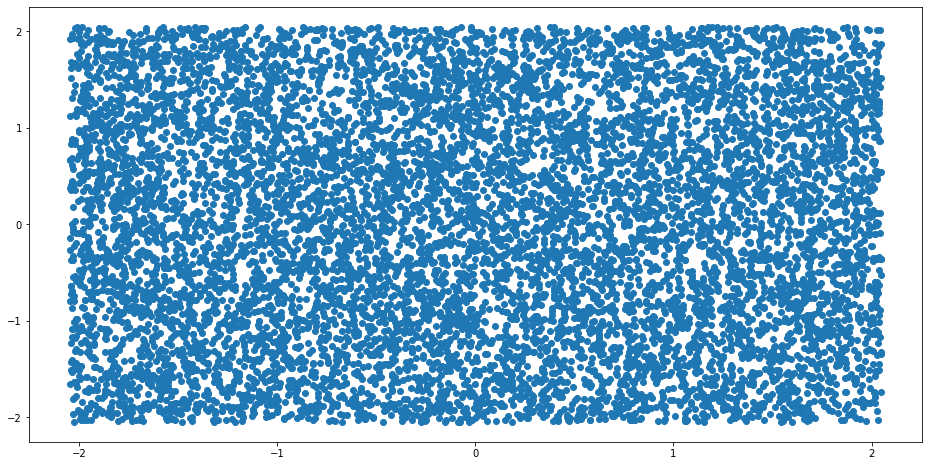

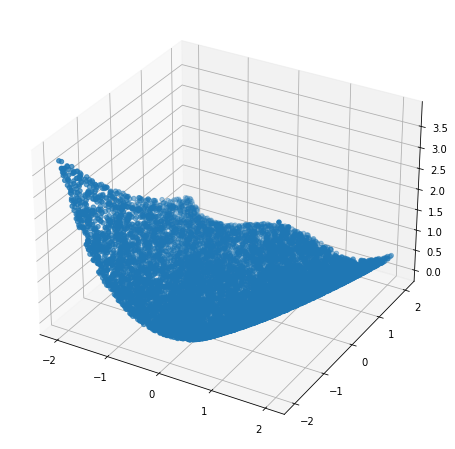

Epoch 1/100, Loss: 8.056302248766496 
Epoch 2/100, Loss: 2.0679438575288986 
Epoch 3/100, Loss: 1.5134613577177891 
Epoch 4/100, Loss: 0.9958388735713453 
Epoch 5/100, Loss: 0.7542193702559733 
Epoch 6/100, Loss: 0.7078068209838247 
Epoch 7/100, Loss: 0.6736242614698172 
Epoch 8/100, Loss: 0.6345705715825594 
Epoch 9/100, Loss: 0.6378962110235609 
Epoch 10/100, Loss: 0.6293461962702799 
Epoch 11/100, Loss: 0.13263163652853224 
Epoch 12/100, Loss: 0.07393640798716984 
Epoch 13/100, Loss: 0.09482598150528124 
Epoch 14/100, Loss: 0.05032277062515043 
Epoch 15/100, Loss: 0.07924310766743584 
Epoch 16/100, Loss: 0.06370945366718972 
Epoch 17/100, Loss: 0.06807401929875509 
Epoch 18/100, Loss: 0.07547240080637173 
Epoch 19/100, Loss: 0.053724968482547666 
Epoch 20/100, Loss: 0.07523297779898651 
Epoch 21/100, Loss: 0.0663752070818645 
Epoch 22/100, Loss: 0.09787799525798185 
Epoch 23/100, Loss: 0.047067461102112865 
Epoch 24/100, Loss: 0.043233409407775515 
Epoch 25/100, Loss: 0.053691120504

In [22]:
model_dense = NN_Model().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Rosenbrock_dense.pth",100)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [23]:
PATH_dense = "Rosenbrock_dense.pth"
model_dense = NN_Model().double()
model_dense.load_state_dict(torch.load(PATH_dense))

<All keys matched successfully>

In [16]:
Rosenbrock(np.array([[1, 1]])) 

array([0.])

In [51]:
ls1,ls2 = apply_Optim_mean(2,model_dense)
ls1

2022-09-26 20:13:40,836 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0   
2022-09-26 20:13:42,868 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [1.0964303  1.27259917]
/home/fatima.albreiki/.conda/envs/CV703/lib/python3.9/site-packages/pygad/pygad.py:473: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=m

[array([1.0964303 , 1.27259917]),
 array([0.91812393, 0.80089337]),
 array([0.7373661 , 0.51421791]),
 array([1.06914319, 1.15269791]),
 array([1.12499   , 1.30447182])]

In [20]:
ls2

[array([1.04325069, 1.05807555]),
 array([1.09142111, 1.20962877]),
 array([1.11300515, 1.20836464]),
 array([0.90428232, 0.76754909]),
 array([1.02063017, 0.91537439])]

In [25]:
def plot_contours_modified(model,PS_list,GA_list):
    
    X = np.linspace(-2,2,50)
    Y = np.linspace(-2,2,50)
    Z1 = compute(X,Y,Rosenbrock)
    Z2 = compute(X,Y,model)
    Z3 = Z2
    X,Y = np.meshgrid(X,Y)
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))
    ax1.contourf(X,Y,Z1,20, cmap='RdGy')
    ax1.scatter(1,1,color="red")
    ax2.contourf(X,Y,Z2,20, cmap='RdGy')
    ax2.scatter(1,1,color="red")
    ax2.scatter(PS_list[0][0],PS_list[0][1])  
    ax2.scatter(PS_list[1][0],PS_list[1][1])  
    ax2.scatter(PS_list[2][0],PS_list[2][1])  
    ax2.scatter(PS_list[3][0],PS_list[3][1])  
    ax2.scatter(PS_list[4][0],PS_list[4][1])
    ax3.contourf(X,Y,Z3,20, cmap='RdGy')
    ax3.scatter(1,1,color="red")
    ax3.scatter(GA_list[0][0],GA_list[0][1])  
    ax3.scatter(GA_list[1][0],GA_list[1][1])  
    ax3.scatter(GA_list[2][0],GA_list[2][1])  
    ax3.scatter(GA_list[3][0],GA_list[3][1])  
    ax3.scatter(GA_list[4][0],GA_list[4][1]) 

    plt.tight_layout() 
    plt.show()



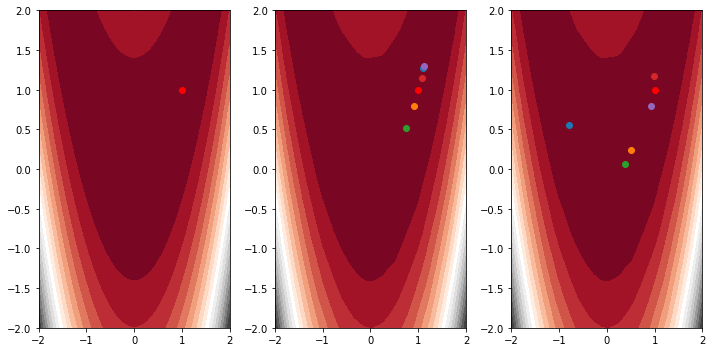

In [52]:
plot_contours_modified(model_dense,ls1,ls2)

In [27]:
from scipy.spatial import distance


def Rosenbrock_for_ga(X,a=1,b=100):
    Z = (a - X[0]) ** 2 + b * (X[1] - X[0] ** 2) ** 2
    Z = Z / 1000
    return Z

def apply_Optim_mean_for_calc_func(dimension,ps_func,ga_func):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(10):
        pos = apply_swarm(ps_func,dimension,i)
        sol = apply_GA(ga_func,dimension,i)
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list


def mean_std(dimension,ps_func,ga_func):
    
    sol_swarm_list,sol_GA_list = apply_Optim_mean_for_calc_func(dimension,ps_func,ga_func)
    min_pt = np.ones((dimension))
    swarm_dist = [] 
    GA_dist = []
    for i in range(10):
        swarm_dist.append(distance.euclidean(min_pt,sol_swarm_list[i]))
        GA_dist.append(distance.euclidean(min_pt,sol_GA_list[i]))
        
    mean_swarm_dist = np.mean(swarm_dist)
    std_swarm_dist = np.std(swarm_dist)
   
    mean_GA_dist= np.mean(GA_dist)
    std_GA_dist = np.std(GA_dist)
    
    return mean_swarm_dist,std_swarm_dist,mean_GA_dist,std_GA_dist


mean_swarm_dist_func,std_swarm_dist_func,mean_GA_dist_func,std_GA_dist_func = mean_std(2,Rosenbrock,Rosenbrock_for_ga)


2022-09-26 19:57:45,471 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=4.44e-34
2022-09-26 19:57:47,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.437342591868191e-34, best pos: [1. 1.]
2022-09-26 19:57:47,524 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0      
2022-09-26 19:57:49,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [1. 1.]
2022-09-26 19:57:49,517 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0      
2022-09-26 19:57:51,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [1. 1.]
2022-09-26 19:57:51,5

In [28]:
mean_swarm_dist_func,std_swarm_dist_func,mean_GA_dist_func,std_GA_dist_func

(1.9860273225978186e-16,
 4.550560269027492e-16,
 1.3164643581986062,
 0.46966914555981026)

# Sparse

/tmp/ipykernel_3185982/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


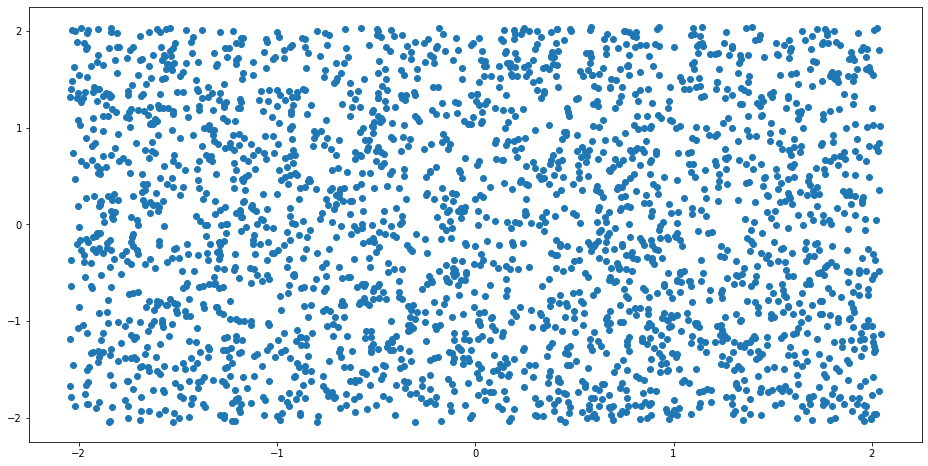

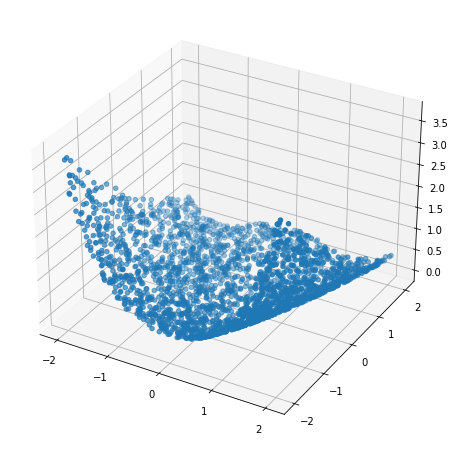

Epoch 1/100, Loss: 37.6945600699705 
Epoch 2/100, Loss: 10.208995649929431 
Epoch 3/100, Loss: 3.8412358835160085 
Epoch 4/100, Loss: 2.663296152634392 
Epoch 5/100, Loss: 2.531225799888928 
Epoch 6/100, Loss: 2.1143461549197027 
Epoch 7/100, Loss: 2.0710731126523245 
Epoch 8/100, Loss: 1.8630396295542428 
Epoch 9/100, Loss: 1.8337212111828924 
Epoch 10/100, Loss: 1.8048284134936021 
Epoch 11/100, Loss: 1.680219780453797 
Epoch 12/100, Loss: 1.690769044763419 
Epoch 13/100, Loss: 1.6887613059653397 
Epoch 14/100, Loss: 1.5380596789040775 
Epoch 15/100, Loss: 1.3408838199150535 
Epoch 16/100, Loss: 1.2090703314009863 
Epoch 17/100, Loss: 1.0931868546472354 
Epoch 18/100, Loss: 1.0992188072590223 
Epoch 19/100, Loss: 0.8840584474335248 
Epoch 20/100, Loss: 0.8091186155055636 
Epoch 21/100, Loss: 0.7763259517223733 
Epoch 22/100, Loss: 0.6499330225501907 
Epoch 23/100, Loss: 0.7170902174561506 
Epoch 24/100, Loss: 0.6193805315778645 
Epoch 25/100, Loss: 0.5723216611451626 
Epoch 26/100, L

In [33]:
model_sparse = NN_Model().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Rosenbrock_sparse.pth",100)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [34]:
PATH_sparse = "Rosenbrock_sparse.pth"
model_sparse = NN_Model().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))

<All keys matched successfully>

In [35]:
ls1_sparse,ls2_sparse = apply_Optim_mean(2,model_sparse)
ls1_sparse

2022-09-26 19:59:51,979 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 19:59:54,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.39136141  0.30794875]
2022-09-26 19:59:54,616 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 19:59:56,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.58174873  0.89999842]
2022-09-26 19:59:56,930 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 19:59:59,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.61928687  0.33200787]
2022

[array([-0.39136141,  0.30794875]),
 array([-0.58174873,  0.89999842]),
 array([-0.61928687,  0.33200787]),
 array([1.06914319, 1.15269791]),
 array([0.86334046, 0.45465724])]

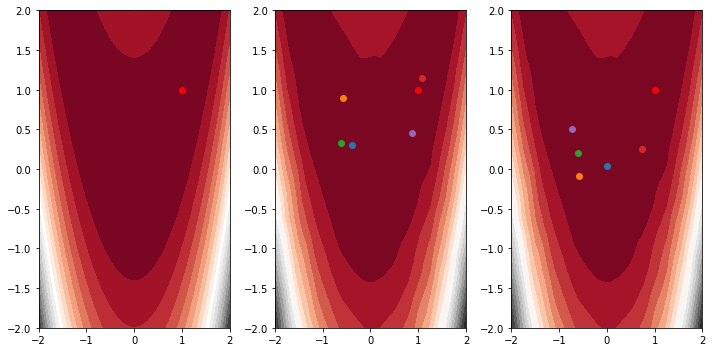

In [36]:
plot_contours_modified(model_sparse,ls1_sparse,ls2_sparse)

In [37]:
from scipy.spatial import distance

def mean_std(dimension,model):
    
    sol_swarm_list,sol_GA_list = apply_Optim_mean_for_calc(dimension,model)
    min_pt = np.ones((dimension))
    swarm_dist = [] 
    GA_dist = []
    for i in range(10):
        swarm_dist.append(distance.euclidean(min_pt,sol_swarm_list[i]))
        GA_dist.append(distance.euclidean(min_pt,sol_GA_list[i]))
        
    mean_swarm_dist = np.mean(swarm_dist)
    std_swarm_dist = np.std(swarm_dist)
   
    mean_GA_dist= np.mean(GA_dist)
    std_GA_dist = np.std(GA_dist)
    
    return mean_swarm_dist,std_swarm_dist,mean_GA_dist,std_GA_dist
    

In [38]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(2,model_dense)

2022-09-26 20:00:29,437 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0   
2022-09-26 20:00:31,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.96600753 0.9058595 ]
2022-09-26 20:00:31,889 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0   
2022-09-26 20:00:34,112 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.74378247 0.52623457]
2022-09-26 20:00:34,352 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0    
2022-09-26 20:00:36,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.65711919 0.41757734]


In [39]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense

(0.46333001512059546,
 0.2967308899131437,
 0.9469616466433571,
 0.41382262231837813)

In [40]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(2,model_sparse)

2022-09-26 20:01:07,500 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:01:09,707 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.39136141  0.30794875]
2022-09-26 20:01:09,950 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:01:12,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.58174873  0.89999842]
2022-09-26 20:01:12,303 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:01:14,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.61928687  0.33200787]
2022

In [41]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse

(1.3420511094829697, 0.5773236584615987, 1.5689589793995595, 0.36977902610283)

# Gauss


/tmp/ipykernel_3185982/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


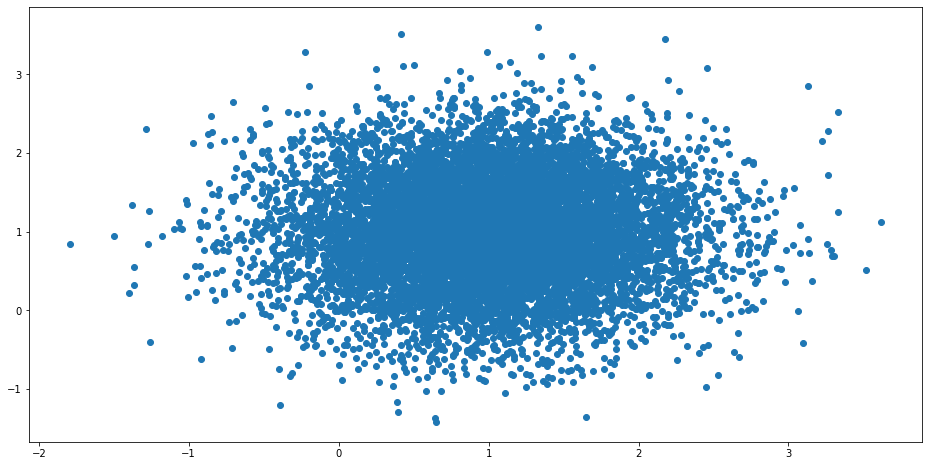

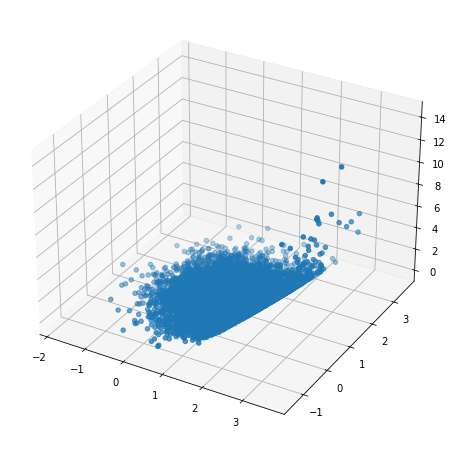

Epoch 1/100, Loss: 17.456974796872977 
Epoch 2/100, Loss: 8.059282724531746 
Epoch 3/100, Loss: 7.788217145321177 
Epoch 4/100, Loss: 7.244821826451817 
Epoch 5/100, Loss: 7.063885077079606 
Epoch 6/100, Loss: 6.3366533786352095 
Epoch 7/100, Loss: 5.925538391275713 
Epoch 8/100, Loss: 4.992641661272034 
Epoch 9/100, Loss: 3.9734062975785007 
Epoch 10/100, Loss: 2.7870632269825037 
Epoch 11/100, Loss: 1.2617815235754657 
Epoch 12/100, Loss: 1.0206566529453143 
Epoch 13/100, Loss: 0.7359393517473273 
Epoch 14/100, Loss: 0.806625748846818 
Epoch 15/100, Loss: 0.47517556691158713 
Epoch 16/100, Loss: 0.44177116875500205 
Epoch 17/100, Loss: 0.47586198256356216 
Epoch 18/100, Loss: 0.33211805933535676 
Epoch 19/100, Loss: 0.5408553921936006 
Epoch 20/100, Loss: 0.2808039680852554 
Epoch 21/100, Loss: 0.3568827008825929 
Epoch 22/100, Loss: 0.21025703827844272 
Epoch 23/100, Loss: 0.21461617308744058 
Epoch 24/100, Loss: 0.37030332910057984 
Epoch 25/100, Loss: 0.24747480874326186 
Epoch 26

In [42]:
model_gauss = NN_Model().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Rosenbrock_gauss.pth",100)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [43]:
PATH_gauss = "Rosenbrock_gauss.pth"
model_gauss = NN_Model().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))

<All keys matched successfully>

In [44]:
ls1_gauss,ls2_gauss = apply_Optim_mean(2,model_gauss)
ls1_gauss

2022-09-26 20:04:24,838 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:04:27,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.00068536 -0.05701392]
2022-09-26 20:04:27,273 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:04:29,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.8452974   0.69952177]
2022-09-26 20:04:29,727 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:04:32,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.61928687  0.33200787]
2022

[array([-0.00068536, -0.05701392]),
 array([-0.8452974 ,  0.69952177]),
 array([-0.61928687,  0.33200787]),
 array([-0.16646238,  0.1375291 ]),
 array([-0.2228897 , -0.34108695])]

In [45]:
ls1_gauss,ls2_gauss

([array([-0.00068536, -0.05701392]),
  array([-0.8452974 ,  0.69952177]),
  array([-0.61928687,  0.33200787]),
  array([-0.16646238,  0.1375291 ]),
  array([-0.2228897 , -0.34108695])],
 [array([-0.25244802,  0.16956634]),
  array([0.51908049, 0.4135536 ]),
  array([-0.17294263, -0.28588668]),
  array([-0.35609598, -0.26880147]),
  array([-0.18450854, -0.43808464])])

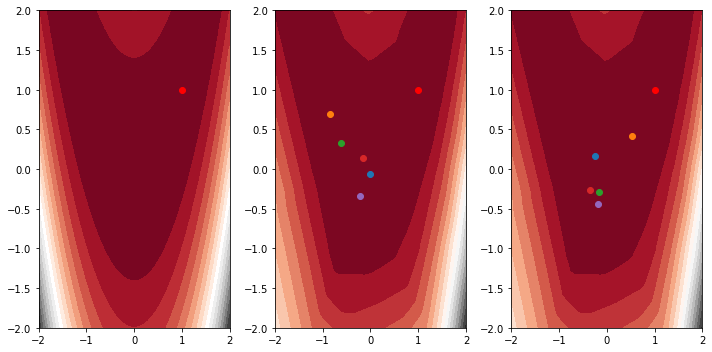

In [46]:
plot_contours_modified(model_gauss,ls1_gauss,ls2_gauss)

In [47]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(2,model_gauss)

2022-09-26 20:05:16,971 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:05:19,275 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.00068536 -0.05701392]
2022-09-26 20:05:19,523 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:05:21,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.8452974   0.69952177]
2022-09-26 20:05:22,035 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-26 20:05:24,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.61928687  0.33200787]
2022

In [48]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss 

(1.4856187262677456,
 0.36461287301481965,
 1.527932984578356,
 0.31725543207182827)

# 4D Rosen

In [93]:
class Model_4D(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(4,15)
        self.Linear2 = nn.Linear(15,50)
        self.Linear3 = nn.Linear(50,15)
        self.Linear4 = nn.Linear(15,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 

In [94]:
# 4D

def Rosenbrock4D(X):
    summ = 0
    for i in range(X.shape[0]-1):
        new = 100*((X[i+1]-X[i]**2)**2) + (X[i]-1)**2
        summ = summ + new
    Z = summ/1000
    return Z  

In [95]:
def get_loaders_types(data_type):
    inputs_array, targets_array = generate_data_types(10000,[1,1,1,1], data_type)
#     plot2d(inputs_array)
#     plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader



In [96]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-2.048,2.048, size=(num_points, 4))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-2.048,2.048, size=(num_points_sparse, 4))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((4)) * 2.048/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 4])
        
    
    func_out = np.array([Rosenbrock4D(p) for p in points])
    return points, func_out



In [97]:
model_dense = Model_4D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Rosenbrock_dense_4.pth",100)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/100, Loss: 81.94231366735187 
Epoch 2/100, Loss: 10.451139737076902 
Epoch 3/100, Loss: 5.4371408664504575 
Epoch 4/100, Loss: 3.1226705881211014 
Epoch 5/100, Loss: 2.481068334208531 
Epoch 6/100, Loss: 2.19267629991667 
Epoch 7/100, Loss: 1.8278602607802248 
Epoch 8/100, Loss: 1.6912734013918507 
Epoch 9/100, Loss: 1.3517201788504045 
Epoch 10/100, Loss: 1.339447931748737 
Epoch 11/100, Loss: 1.1819882534448158 
Epoch 12/100, Loss: 1.2912517151329566 
Epoch 13/100, Loss: 1.2414295475370112 
Epoch 14/100, Loss: 1.1866469557753834 
Epoch 15/100, Loss: 1.2037284979095533 
Epoch 16/100, Loss: 1.062807066807256 
Epoch 17/100, Loss: 1.0015537459136985 
Epoch 18/100, Loss: 1.160899968523333 
Epoch 19/100, Loss: 1.0919669066886424 
Epoch 20/100, Loss: 0.8226059873576838 
Epoch 21/100, Loss: 1.0096633654028593 
Epoch 22/100, Loss: 1.0173270228843907 
Epoch 23/100, Loss: 0.7218030692708023 
Epoch 24/100, Loss: 0.8581512551093711 
Epoch 25/100, Loss: 0.8159447979036446 
Epoch 26/100, Lo

In [98]:
PATH_dense = "Rosenbrock_dense_4.pth"
model_dense = Model_4D().double()
model_dense.load_state_dict(torch.load(PATH_dense))

<All keys matched successfully>

In [99]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(4,model_dense)

2022-09-24 12:08:02,765 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00568
2022-09-24 12:08:04,865 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.005676678913039371, best pos: [1.14286116 0.94156888 1.04827283 1.58785167]
2022-09-24 12:08:05,165 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00569
2022-09-24 12:08:07,072 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.005693878326379548, best pos: [1.14104398 0.94531503 1.05245057 1.59390221]
2022-09-24 12:08:07,381 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00567
2022-09-24 12:08:09,191 - pyswarms.single.global_be

In [100]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense 

(0.6015275788464244,
 0.030606747252568827,
 1.5920209113525778,
 0.7427473610077622)

In [101]:
model_sparse = Model_4D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Rosenbrock_sparse_4.pth",100)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/100, Loss: 167.38358662469156 
Epoch 2/100, Loss: 62.0242875933745 
Epoch 3/100, Loss: 27.87728724892004 
Epoch 4/100, Loss: 17.280096080506254 
Epoch 5/100, Loss: 13.463731491809956 
Epoch 6/100, Loss: 11.007876910390726 
Epoch 7/100, Loss: 8.994613021596178 
Epoch 8/100, Loss: 7.9851191005766005 
Epoch 9/100, Loss: 6.543837530513983 
Epoch 10/100, Loss: 5.53959558017575 
Epoch 11/100, Loss: 4.827655519572148 
Epoch 12/100, Loss: 4.077821409504694 
Epoch 13/100, Loss: 4.486185304757129 
Epoch 14/100, Loss: 3.0435049873313083 
Epoch 15/100, Loss: 2.6176443840643433 
Epoch 16/100, Loss: 2.599192485624545 
Epoch 17/100, Loss: 2.3361223684444274 
Epoch 18/100, Loss: 2.382790205613707 
Epoch 19/100, Loss: 2.695868229287901 
Epoch 20/100, Loss: 2.0529370203872594 
Epoch 21/100, Loss: 2.009123288144579 
Epoch 22/100, Loss: 2.52032664906405 
Epoch 23/100, Loss: 2.048411617314129 
Epoch 24/100, Loss: 1.9022089641377427 
Epoch 25/100, Loss: 2.2006956421551203 
Epoch 26/100, Loss: 1.8807

In [134]:
PATH_sparse = "Rosenbrock_sparse_4.pth"
model_sparse = Model_4D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))

<All keys matched successfully>

In [135]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(4,model_sparse)

2022-09-24 13:07:17,982 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-.000527
2022-09-24 13:07:19,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0005267417699483801, best pos: [1.01305135 0.72224888 0.49969177 0.3292976 ]
2022-09-24 13:07:20,143 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-.000417
2022-09-24 13:07:22,087 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.00041713511553331806, best pos: [1.0231874  0.73056068 0.55371482 0.40297423]
2022-09-24 13:07:22,372 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-.00052
2022-09-24 13:07:24,408 - pyswarms.single.gl

In [136]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse

(0.8648597280332139,
 0.060938961886662465,
 1.562224203958638,
 0.7162841608834621)

In [109]:
model_gauss = Model_4D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Rosenbrock_gauss_4.pth",100)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/100, Loss: 102.18487986998566 
Epoch 2/100, Loss: 15.858564283137001 
Epoch 3/100, Loss: 9.200675036681812 
Epoch 4/100, Loss: 6.470824352354023 
Epoch 5/100, Loss: 4.582179064915907 
Epoch 6/100, Loss: 2.621788456460346 
Epoch 7/100, Loss: 6.049199549679852 
Epoch 8/100, Loss: 3.66487774346269 
Epoch 9/100, Loss: 2.3971456812564127 
Epoch 10/100, Loss: 4.045650030004219 
Epoch 11/100, Loss: 3.364282407083576 
Epoch 12/100, Loss: 3.52043704877568 
Epoch 13/100, Loss: 2.7910270433152733 
Epoch 14/100, Loss: 2.2515190955378124 
Epoch 15/100, Loss: 4.030061513583452 
Epoch 16/100, Loss: 1.9630048980533585 
Epoch 17/100, Loss: 4.019379179497821 
Epoch 18/100, Loss: 3.601752957840737 
Epoch 19/100, Loss: 1.924792818885451 
Epoch 20/100, Loss: 1.624110874497302 
Epoch 21/100, Loss: 5.796325991968493 
Epoch 22/100, Loss: 1.6508336060982933 
Epoch 23/100, Loss: 1.5802328859039825 
Epoch 24/100, Loss: 4.311880486277866 
Epoch 25/100, Loss: 1.671609541559679 
Epoch 26/100, Loss: 2.605532

In [110]:
PATH_gauss = "Rosenbrock_gauss_4.pth"
model_gauss = Model_4D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))

<All keys matched successfully>

In [111]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(4,model_gauss)

2022-09-24 12:33:16,770 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0559
2022-09-24 12:33:18,673 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.055928814384545916, best pos: [-0.89339626  0.58385603 -0.86506836 -0.08083589]
2022-09-24 12:33:18,938 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0559
2022-09-24 12:33:20,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.055928814384545916, best pos: [-0.04889323  0.65057203 -0.93345607 -1.36181973]
2022-09-24 12:33:21,163 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0559
2022-09-24 12:33:23,114 - pyswarms.single.glob

In [112]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss

(2.5192729292468554,
 0.5701282092910339,
 2.4941681271791207,
 0.8532189669738225)

# 10D Rosen

In [113]:
class Model_10D(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = nn.Linear(10,15)
        self.Linear2 = nn.Linear(15,50)
        self.Linear3 = nn.Linear(50,15)
        self.Linear4 = nn.Linear(15,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 

In [114]:
#10D
def Rosenbrock10D(X):
    summ = 0
    for i in range(X.shape[0]-1):
        new = 100*((X[i+1]-X[i]**2)**2) + (X[i]-1)**2
        summ = summ + new
    Z = summ/1000
    return Z  

In [117]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-2.048,2.048, size=(num_points, 10))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-2.048,2.048, size=(num_points_sparse, 10))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((10)) * 2.048/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 10])
        
    
    func_out = np.array([Rosenbrock10D(p) for p in points])
    return points, func_out




In [118]:
def get_loaders_types(data_type):
    pt = np.ones(10)
    inputs_array, targets_array = generate_data_types(10000,pt, data_type)
#     plot2d(inputs_array)
#     plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader



In [144]:
model_dense = Model_10D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Rosenbrock_dense_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 576.2873663093842 
Epoch 2/500, Loss: 240.9318330083517 
Epoch 3/500, Loss: 179.68948745181692 
Epoch 4/500, Loss: 156.05508561362532 
Epoch 5/500, Loss: 141.86131208543915 
Epoch 6/500, Loss: 130.11976208570448 
Epoch 7/500, Loss: 119.98536185789737 
Epoch 8/500, Loss: 110.7927603396054 
Epoch 9/500, Loss: 101.98157303646282 
Epoch 10/500, Loss: 94.84774739820465 
Epoch 11/500, Loss: 88.36835683960595 
Epoch 12/500, Loss: 81.704287447759 
Epoch 13/500, Loss: 76.1740991343199 
Epoch 14/500, Loss: 71.37156554053875 
Epoch 15/500, Loss: 67.19823628011963 
Epoch 16/500, Loss: 63.0315824048869 
Epoch 17/500, Loss: 59.53816776713519 
Epoch 18/500, Loss: 56.769663115501224 
Epoch 19/500, Loss: 54.48210472343299 
Epoch 20/500, Loss: 51.00211030984489 
Epoch 21/500, Loss: 49.18342568282736 
Epoch 22/500, Loss: 47.47128048674897 
Epoch 23/500, Loss: 46.63006369604833 
Epoch 24/500, Loss: 45.388445892811426 
Epoch 25/500, Loss: 43.578691854586594 
Epoch 26/500, Loss: 42.637426

Epoch 206/500, Loss: 14.48083107449836 
Epoch 207/500, Loss: 14.4333818047015 
Epoch 208/500, Loss: 14.490416127115806 
Epoch 209/500, Loss: 14.661770088360067 
Epoch 210/500, Loss: 14.350508185006605 
Epoch 211/500, Loss: 14.234730765952644 
Epoch 212/500, Loss: 14.536438607054237 
Epoch 213/500, Loss: 14.022766959921308 
Epoch 214/500, Loss: 14.532322816888543 
Epoch 215/500, Loss: 14.38430157962233 
Epoch 216/500, Loss: 14.389012732118342 
Epoch 217/500, Loss: 14.33860377029673 
Epoch 218/500, Loss: 14.130402378547645 
Epoch 219/500, Loss: 14.905473487396325 
Epoch 220/500, Loss: 13.930394911571032 
Epoch 221/500, Loss: 13.96297083120943 
Epoch 222/500, Loss: 14.014249821149775 
Epoch 223/500, Loss: 14.062284716799585 
Epoch 224/500, Loss: 14.380371171260707 
Epoch 225/500, Loss: 14.44875943746862 
Epoch 226/500, Loss: 14.159298966095442 
Epoch 227/500, Loss: 13.941444801330558 
Epoch 228/500, Loss: 14.13342786268316 
Epoch 229/500, Loss: 13.938847836331322 
Epoch 230/500, Loss: 14.

Epoch 408/500, Loss: 10.691140621778967 
Epoch 409/500, Loss: 10.914195189901786 
Epoch 410/500, Loss: 10.559524935143099 
Epoch 411/500, Loss: 10.824735636381545 
Epoch 412/500, Loss: 10.717776886217656 
Epoch 413/500, Loss: 10.690137727287514 
Epoch 414/500, Loss: 10.3664538853776 
Epoch 415/500, Loss: 10.97434553943532 
Epoch 416/500, Loss: 10.76703768710025 
Epoch 417/500, Loss: 10.798618267818558 
Epoch 418/500, Loss: 10.420932270508354 
Epoch 419/500, Loss: 10.786363622482716 
Epoch 420/500, Loss: 10.778374142355476 
Epoch 421/500, Loss: 10.964975353252466 
Epoch 422/500, Loss: 10.744958643331367 
Epoch 423/500, Loss: 10.80661091394873 
Epoch 424/500, Loss: 10.552334506011235 
Epoch 425/500, Loss: 10.624172182126845 
Epoch 426/500, Loss: 10.52990214289812 
Epoch 427/500, Loss: 10.425692002875909 
Epoch 428/500, Loss: 10.694464049213686 
Epoch 429/500, Loss: 10.798815678430019 
Epoch 430/500, Loss: 10.523157536830995 
Epoch 431/500, Loss: 10.462260264851803 
Epoch 432/500, Loss: 1

In [145]:
PATH_dense = "Rosenbrock_dense_10.pth"
model_dense = Model_10D().double()
model_dense.load_state_dict(torch.load(PATH_dense))


<All keys matched successfully>

In [146]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(10,model_dense)
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense 

2022-09-24 13:34:28,561 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.288
2022-09-24 13:34:30,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2882314010476532, best pos: [-0.52684917  1.02056747  0.72949955  0.77808079  0.37408992  0.2015591
 -0.52601316 -0.31415396  0.42805849  1.00192777]
2022-09-24 13:34:30,827 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.277
2022-09-24 13:34:32,704 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2766698029023303, best pos: [-0.11177199  0.29343792 -0.08109088  0.16946808  0.39525687 -0.19596524
 -0.11478789  0.02394991  0.62389514  1.05912139]
2022-09-24 13:34:32,991 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, '

(2.6456849796262434, 0.2203473082774103, 3.322443268463173, 0.6232915762379483)

In [147]:
model_sparse = Model_10D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Rosenbrock_sparse_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 1054.1499292612646 
Epoch 2/500, Loss: 323.6468077902219 
Epoch 3/500, Loss: 301.5076652557512 
Epoch 4/500, Loss: 279.89075401026054 
Epoch 5/500, Loss: 256.93082642065997 
Epoch 6/500, Loss: 236.52536105211286 
Epoch 7/500, Loss: 212.76363172101077 
Epoch 8/500, Loss: 190.19490778909812 
Epoch 9/500, Loss: 169.4990624617121 
Epoch 10/500, Loss: 155.17033472217997 
Epoch 11/500, Loss: 146.25968956764376 
Epoch 12/500, Loss: 139.30366948618249 
Epoch 13/500, Loss: 133.68190134346202 
Epoch 14/500, Loss: 127.79821648668162 
Epoch 15/500, Loss: 122.43682352390319 
Epoch 16/500, Loss: 121.12990818114457 
Epoch 17/500, Loss: 114.67723440758502 
Epoch 18/500, Loss: 113.71504798693422 
Epoch 19/500, Loss: 107.23880310905875 
Epoch 20/500, Loss: 107.68048335451584 
Epoch 21/500, Loss: 104.83730429212152 
Epoch 22/500, Loss: 102.4260653821447 
Epoch 23/500, Loss: 98.56097021805225 
Epoch 24/500, Loss: 96.53165699870944 
Epoch 25/500, Loss: 93.91986568481106 
Epoch 26/500, Lo

Epoch 207/500, Loss: 27.792439087698515 
Epoch 208/500, Loss: 27.834412226048745 
Epoch 209/500, Loss: 27.606384319758437 
Epoch 210/500, Loss: 26.912756376974517 
Epoch 211/500, Loss: 27.625669460453803 
Epoch 212/500, Loss: 26.810446378376266 
Epoch 213/500, Loss: 27.488623507863473 
Epoch 214/500, Loss: 27.767544213136475 
Epoch 215/500, Loss: 28.496955104592704 
Epoch 216/500, Loss: 26.415718555713575 
Epoch 217/500, Loss: 27.753246929742836 
Epoch 218/500, Loss: 27.846319449018694 
Epoch 219/500, Loss: 26.975390710045392 
Epoch 220/500, Loss: 27.37214453857406 
Epoch 221/500, Loss: 26.455137198585383 
Epoch 222/500, Loss: 26.18507580782761 
Epoch 223/500, Loss: 27.818380661948684 
Epoch 224/500, Loss: 25.870082514345967 
Epoch 225/500, Loss: 25.925499620564498 
Epoch 226/500, Loss: 26.184046027029527 
Epoch 227/500, Loss: 25.498271020244623 
Epoch 228/500, Loss: 28.101226054842485 
Epoch 229/500, Loss: 25.514318338377816 
Epoch 230/500, Loss: 27.12337801490909 
Epoch 231/500, Loss

Epoch 409/500, Loss: 18.310127849023438 
Epoch 410/500, Loss: 18.898636730148738 
Epoch 411/500, Loss: 18.432925534635505 
Epoch 412/500, Loss: 19.814426430372233 
Epoch 413/500, Loss: 19.27040980473618 
Epoch 414/500, Loss: 17.886879410096554 
Epoch 415/500, Loss: 18.889532551049015 
Epoch 416/500, Loss: 18.20278018244095 
Epoch 417/500, Loss: 18.47326948785445 
Epoch 418/500, Loss: 19.218593168383265 
Epoch 419/500, Loss: 18.8163170921346 
Epoch 420/500, Loss: 19.01857632216928 
Epoch 421/500, Loss: 18.76832798405075 
Epoch 422/500, Loss: 18.990021239451664 
Epoch 423/500, Loss: 18.82694072660073 
Epoch 424/500, Loss: 18.399844853877955 
Epoch 425/500, Loss: 18.683009693713927 
Epoch 426/500, Loss: 19.097516447138787 
Epoch 427/500, Loss: 18.142153439389922 
Epoch 428/500, Loss: 18.26475541825649 
Epoch 429/500, Loss: 19.41519974613188 
Epoch 430/500, Loss: 20.323824941657783 
Epoch 431/500, Loss: 18.108279190110025 
Epoch 432/500, Loss: 19.03840664267262 
Epoch 433/500, Loss: 17.669

In [148]:
PATH_sparse = "Rosenbrock_sparse_10.pth"
model_sparse = Model_10D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))


<All keys matched successfully>

In [149]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(10,model_sparse)
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse 

2022-09-24 13:37:36,178 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-.195
2022-09-24 13:37:38,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1949965047430113, best pos: [ 0.22406853 -0.29008086 -0.19031029 -0.06379522 -0.06390189  0.11425407
  0.26559739 -0.00994336 -0.06637238  0.70064401]
2022-09-24 13:37:38,700 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-.195
2022-09-24 13:37:40,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.1949965047430113, best pos: [ 0.16135805 -0.30137359 -0.27799773 -0.07827224 -0.02783866 -0.06343398
  0.2697564   0.18842166  0.12660278  1.43056889]
2022-09-24 13:37:41,224 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5

(3.057167582716267,
 0.041355058522937096,
 2.887885216703159,
 0.5912161642016572)

In [150]:
model_gauss = Model_10D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Rosenbrock_gauss_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 508.71082124416716 
Epoch 2/500, Loss: 326.49079433276944 
Epoch 3/500, Loss: 219.3471887441471 
Epoch 4/500, Loss: 146.32055464792253 
Epoch 5/500, Loss: 113.84981173126492 
Epoch 6/500, Loss: 93.9080211531715 
Epoch 7/500, Loss: 82.07573350895468 
Epoch 8/500, Loss: 72.53577783069854 
Epoch 9/500, Loss: 64.24178824973669 
Epoch 10/500, Loss: 56.118494765991464 
Epoch 11/500, Loss: 49.489015018995126 
Epoch 12/500, Loss: 44.98196907279901 
Epoch 13/500, Loss: 41.47225055260519 
Epoch 14/500, Loss: 36.3154308249339 
Epoch 15/500, Loss: 34.808439429181874 
Epoch 16/500, Loss: 31.179646596806407 
Epoch 17/500, Loss: 28.96913712468274 
Epoch 18/500, Loss: 27.831852202938823 
Epoch 19/500, Loss: 27.13859904815828 
Epoch 20/500, Loss: 26.88437012831099 
Epoch 21/500, Loss: 24.321456333024962 
Epoch 22/500, Loss: 23.415966685679436 
Epoch 23/500, Loss: 22.593976214372375 
Epoch 24/500, Loss: 21.537117399542925 
Epoch 25/500, Loss: 19.747702610687025 
Epoch 26/500, Loss: 21

Epoch 208/500, Loss: 5.3930724783821375 
Epoch 209/500, Loss: 5.837043126460653 
Epoch 210/500, Loss: 5.6078613193547815 
Epoch 211/500, Loss: 5.038056529321149 
Epoch 212/500, Loss: 5.015774397211662 
Epoch 213/500, Loss: 5.271959156287567 
Epoch 214/500, Loss: 5.941428580515482 
Epoch 215/500, Loss: 4.994733235668941 
Epoch 216/500, Loss: 5.249913985484523 
Epoch 217/500, Loss: 4.491685970034035 
Epoch 218/500, Loss: 5.624989063718101 
Epoch 219/500, Loss: 5.84950324149475 
Epoch 220/500, Loss: 5.436251227084136 
Epoch 221/500, Loss: 4.370460279018035 
Epoch 222/500, Loss: 4.853621490744702 
Epoch 223/500, Loss: 5.277791175740325 
Epoch 224/500, Loss: 4.731003193144248 
Epoch 225/500, Loss: 5.408012757722691 
Epoch 226/500, Loss: 4.9267066871549945 
Epoch 227/500, Loss: 4.976265292309352 
Epoch 228/500, Loss: 5.265079268034091 
Epoch 229/500, Loss: 4.69214511643464 
Epoch 230/500, Loss: 4.931926670344792 
Epoch 231/500, Loss: 5.176274140250546 
Epoch 232/500, Loss: 5.753670674425366 

Epoch 413/500, Loss: 3.598810548564631 
Epoch 414/500, Loss: 3.491638142781916 
Epoch 415/500, Loss: 3.9882542864824777 
Epoch 416/500, Loss: 3.7131743949625626 
Epoch 417/500, Loss: 3.6518019617973847 
Epoch 418/500, Loss: 3.2510768589223806 
Epoch 419/500, Loss: 3.71812519970961 
Epoch 420/500, Loss: 3.7135273442057706 
Epoch 421/500, Loss: 3.7787889372661287 
Epoch 422/500, Loss: 3.7854660578336508 
Epoch 423/500, Loss: 3.517868117723618 
Epoch 424/500, Loss: 3.7828793769222138 
Epoch 425/500, Loss: 3.224216712232459 
Epoch 426/500, Loss: 3.7126683329508086 
Epoch 427/500, Loss: 3.55293282425185 
Epoch 428/500, Loss: 3.551037155128627 
Epoch 429/500, Loss: 3.9261579203862333 
Epoch 430/500, Loss: 3.3748713637211893 
Epoch 431/500, Loss: 3.8951083007618976 
Epoch 432/500, Loss: 3.533189367077301 
Epoch 433/500, Loss: 3.5323615558291737 
Epoch 434/500, Loss: 3.713503376127788 
Epoch 435/500, Loss: 3.5466525243866682 
Epoch 436/500, Loss: 3.2783862433827657 
Epoch 437/500, Loss: 4.0003

In [151]:
PATH_gauss = "Rosenbrock_gauss_10.pth"
model_gauss = Model_10D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))



<All keys matched successfully>

In [152]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(10,model_gauss)
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss

2022-09-24 13:49:05,616 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.2 
2022-09-24 13:49:07,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1998484507773943, best pos: [1.19479294 1.29650391 1.21264941 1.03256186 0.22827064 0.41542771
 1.24679886 1.35145471 1.3019387  1.28355403]
2022-09-24 13:49:08,210 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.219
2022-09-24 13:49:10,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.21923792408940412, best pos: [-0.54866042  0.06144507  0.0606778   1.000817    0.9633832   0.88977956
  0.5027517  -0.57154976 -0.6354178  -1.7192677 ]
2022-09-24 13:49:10,462 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3,

(3.5283917556246593, 2.252988827982444, 7.1747471823492885, 1.5304762836495156)

# END